Projet 5 - Segmentez des clients d'un site e-commerce - Cleaning  

- Travail sur une base de données relationnelle.
- Classification non-supervisée:
  - selon 3 critères:
     - Recency: durée écoulée depuis la dernière commande du client
     - Frequency: #commandes du client (potentiellement à diviser par la durée totale pendant laquelle le client a été actif, mais vu que certains n'ont fait qu'une seule commande je ne vais pas faire ce calcul pour l'instant)
     - Monetary: somme totale dépensée
  -  avec 3 algorithmes:
     - kmeans
     - dbscan
     - agglomerative/hiérarchique clustering
- Choix d'initiative à prendre pour chaque classe obtenue.
- Raisonnement sur fréquence de màj de cette classification.

>-
# 1. Initialisation, visualization

>>-
## 11. Imports

>>>-
### 111. Package imports

In [6]:
pip install autopep8

Note: you may need to restart the kernel to use updated packages.


In [2]:
jupyter nbextension install https://github.com/kenkoooo/jupyter-autopep8/archive/master.zip --user

SyntaxError: invalid syntax (3266035151.py, line 1)

In [7]:
sudo jupyter nbextension install https://github.com/kenkoooo/jupyter-autopep8/archive/master.zip --user

SyntaxError: invalid syntax (3660637962.py, line 1)

In [1]:
jupyter nbextension enable jupyter-autopep8-master/jupyter-autopep8

SyntaxError: invalid syntax (2912123320.py, line 1)

In [8]:
sudo jupyter nbextension enable jupyter-autopep8-master/jupyter-autopep8

SyntaxError: invalid syntax (1436967131.py, line 1)

In [9]:
sudo jupyter nbextension list

SyntaxError: invalid syntax (1401278626.py, line 1)

In [1]:
import numpy as np              # fast thus always used
import pandas as pd             # fast
pd.set_option("display.max_rows", 20, "display.max_columns", None)
import matplotlib.pyplot as plt # slow: 233 ns
import seaborn as sns           # SLOW BUT: 80.4 ns
sns.set_style("whitegrid")      # "ticks", "white"
import re
import my
import datetime
from scipy import interpolate   # FAST BUT: 319 ns ± 2.64 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
#  %timeit import geopandas     # SLOW 
import timeit
#import os
#import sys
from IPython.display import clear_output
import warnings

>>>-
### 112. Data imports

In [2]:
dfs1 = pd.read_csv("olist_customers_dataset.csv") #, sep="\t")
dfs2 = pd.read_csv("olist_geolocation_dataset.csv") #, sep="\t")
dfs3 = pd.read_csv("olist_order_items_dataset.csv") #, sep="\t")
dfs4 = pd.read_csv("olist_order_payments_dataset.csv") #, sep="\t")
dfs5 = pd.read_csv("olist_order_reviews_dataset.csv") #, sep="\t")
dfs6 = pd.read_csv("olist_orders_dataset.csv") #, sep="\t")
dfs7 = pd.read_csv("olist_products_dataset.csv") #, sep="\t")
dfs8 = pd.read_csv("olist_sellers_dataset.csv") #, sep="\t")
dfs9 = pd.read_csv('product_category_name_translation.csv') #, sep='\t')
dfs = [dfs1, dfs2, dfs3, dfs4, dfs5, dfs6, dfs7, dfs8, dfs9]

Je ne suis pas très content de cette solution pour pouvoir itérer sur les 9 df car je crée un objet dfs gigantesque, alors que je veux juste une liste qui renvoie vers chacun des 9 df sans contenir leur contenu.

>>-
## 12. Fabrication du df par merging

In [3]:
pd.set_option("display.max_rows", 20, "display.max_columns", None)
for df in dfs:
    #print(list(df.columns))
    display(df.head(1))
    display(df.shape)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


(99441, 5)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP


(1000163, 5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29


(112650, 7)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33


(103886, 5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59


(99224, 7)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


(99441, 8)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0


(32951, 9)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP


(3095, 4)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty


(71, 2)

- dfs1 me permettra de remonter au customer unique id à partir du customer id des autres tableaux donc je le garde. J'en retirerai peut-être les données géographiques si elles ont une feature importance basse.
- dfs2 donne juste d'autres façons de traduire les données géographiques. Il ne me servira pas.
- dfs3 donne une date, un prix et un prix de livraison pour chaque commande. Je le garde.
- dfs4 donne le prix de chaque commande. Est-ce redondant avec dfs3 ? À voir.
- dfs5 donne pour chaque commande la note/commentaire laissé par le client. Peut-être que je pourrai m'en servir juste pour savoir pour chaque client le taux de commandes qu'il a notées et que ça aiderait la classification mais j'y crois peu donc je retire ce tableau.
- dfs6 donne la correspondance entre customer id et order id. Il donne aussi la date d'achat, qui devrait être importante. Date redondante avec dfs3 ?
- dfs7 donne des infos sur les produits. Inutile.
- dfs8 donne les données géographiques du vendeur. Inutile.
- dfs9 est une traduction ES-EN de données inutiles.

In [4]:
print("dfs1: " + str(dfs1.shape))
print("dfs6: " + str(dfs6.shape))
df = dfs1[["customer_id","customer_unique_id"]].merge(dfs6[["customer_id","order_id","order_purchase_timestamp"]], on="customer_id", how="outer")
print("df  : " + str(df.shape))
#print("dfs3: " + str(dfs3.shape))
#df = df.merge(dfs3[["order_id","price","freight_value"]], on="order_id", how="outer")
#print("df  : " + str(df.shape))
print("dfs4: " + str(dfs4.shape))
df = df.merge(dfs4[["order_id","payment_value"]], on="order_id", how="outer")
print("df  : " + str(df.shape))

dfs1: (99441, 5)
dfs6: (99441, 8)
df  : (99441, 4)
dfs4: (103886, 5)
df  : (103887, 5)


Le df final fait une ligne de plus que le dfs4.  
Il y a donc soit un doublon qui a été créé soit une entrée du {dfs1 + dfs6} a un "order_id" qui n'existe pas dans dfs4.

>-
# 2. Cleaning

>>-
## 21. Erreurs de merge (ajout de duplicates)

In [5]:
new_elt = list(set(df.order_id).difference(set(dfs4.order_id)))
display(df[["order_purchase_timestamp","payment_value"]][df.order_id == new_elt[0]])

,order_purchase_timestamp,payment_value
22061,2016-09-15 12:16:38,NaN


Vu que cet achat n'existe pas dans dfs4 il n'a pas de donnée renseignée pour la colonne payment_value.  
Le merge avec df4 a ajouté une ligne avec payment_value manquante.  
Je vais supprimer cet élément.

In [6]:
df[["order_id","order_purchase_timestamp","payment_value"]].duplicated(keep=False).sum()

923

Il y a beaucoup de duplicates dans le df mergé.

In [7]:
df[df[["order_id","order_purchase_timestamp","payment_value"]].duplicated(keep=False)][:2]

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,payment_value
312,dcb6e7bc4e65d815025d0aa14349a4ca,a1864cdd58debf5031958069ee937742,dfaa4ce943a8dba10b754befb76fdb49,2017-11-26 15:11:19,189.88
313,dcb6e7bc4e65d815025d0aa14349a4ca,a1864cdd58debf5031958069ee937742,dfaa4ce943a8dba10b754befb76fdb49,2017-11-26 15:11:19,189.88


In [8]:
dfs4[dfs4[["order_id","payment_value"]].duplicated(keep=False)].sort_values(by="order_id")[:10]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
20650,00bd50cdd31bd22e9081e6e2d5b3577b,2,voucher,1,40.46
8869,00bd50cdd31bd22e9081e6e2d5b3577b,3,voucher,1,40.46
52049,00c405bd71187154a7846862f585a9d4,5,voucher,1,0.10
20594,00c405bd71187154a7846862f585a9d4,7,voucher,1,20.00
60979,00c405bd71187154a7846862f585a9d4,3,voucher,1,0.10
26391,00c405bd71187154a7846862f585a9d4,6,voucher,1,20.00
72814,00c95282163553a982f38481f9488481,2,voucher,1,20.00
34579,00c95282163553a982f38481f9488481,4,voucher,1,20.00
60372,00c95282163553a982f38481f9488481,3,voucher,1,20.00
67984,03e5d6a8dd520898f86f8429ccd07c21,1,voucher,1,46.80


In [9]:
dfs4[["order_id","payment_value"]].duplicated(keep=False).sum()

923

On voit que tous ces duplicates étaient déjà dans la base de données initiale donc ce sont juste des clients qui ont acheté plusieurs exemplaires du même item dans leur commande.  
Là j'ai de la chance car le merge n'a rajouté qu'un seul (faux) élément dans le df et il n'apparaît pas ici car il n'a pas de "payment_value". Je peux donc facilement le trouver et le supprimer, je dois juste faire très attention à ne pas utiliser duplicated() pour delete car ici les duplicates ne sont pas des erreurs de remplissage.

In [10]:
dfs4["payment_value"].isna().sum()

0

In [11]:
df["payment_value"].isna().sum()

1

In [12]:
id_sans_payt_val = df["order_id"][df["payment_value"].isna() == True]

L'erreur de merge est très facile à trouver et supprimer ici.

In [13]:
print(df.shape)
df = df[df.order_id != new_elt[0]]
df = my.resindx(df)

(103887, 5)
Il n'y avait pas de colonne 'level_0' indésirable à supprimer.
Une colonne 'index' indésirable a été supprimée.
(103886, 5)


In [14]:
df["payment_value"].isna().sum()

0

>>-
## 22. Feature cleaning

Je nettoie les colonnes inutiles:

In [15]:
keeps = ["customer_unique_id","order_purchase_timestamp","payment_value"]

In [16]:
df = df[keeps]
df.head(2)

,customer_unique_id,order_purchase_timestamp,payment_value
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,146.87
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,335.48


>>-
## 23. Réorganisation vers RFM

In [17]:
df.groupby("customer_unique_id").count().head(2)

,order_purchase_timestamp,payment_value
customer_unique_id,,
0000366f3b9a7992bf8c76cfdf3221e2,1,1
0000b849f77a49e4a4ce2b2a4ca5be3f,1,1


In [18]:
df.groupby("customer_unique_id").count()[df.groupby("customer_unique_id").order_purchase_timestamp.count() > 2].head(2)

,order_purchase_timestamp,payment_value
customer_unique_id,,
0058f300f57d7b93c477a131a59b36c3,3,3
00a9fd000ff87bb48b989df819c418f5,4,4


In [19]:
datetime.datetime.now()

datetime.datetime(2022, 11, 8, 9, 12, 1, 655373)

In [20]:
df.order_purchase_timestamp.max()

'2018-10-17 17:30:18'

In [21]:
df.order_purchase_timestamp.min()

'2016-09-04 21:15:19'

In [22]:
%%script echo
#J'arrête de run cette cell car c'est trop long.
#Naturellement ça va causer une erreur juste en-dessous.
#Faut relancer à partir de dfs = pd.read("dfs_1.csv")

#Évidemment le mieux serait que je fasse mon subsampling avant cette présente cell mais
#dans le souci de "non cleané, pour comprendre votre démarche" je garde tout ceci dans l'ordre de mon raisonnement et
#juste je script echo ces quelques cells

#t0 = datetime.datetime.now()
t0 = datetime.datetime.strptime(df.order_purchase_timestamp.max(), "%Y-%m-%d %H:%M:%S") # %S.%f s'il y a les millièmes de seconde.
tt = pd.Series(name="recency")
for i in range(df.shape[0]):
    tt.loc[i] = (t0 - datetime.datetime.strptime(df["order_purchase_timestamp"][i], "%Y-%m-%d %H:%M:%S")).total_seconds()
tt.head(2)
df["recency"] = tt

Couldn't find program: 'echo'


C'est giga long ce striptime pour chaque élément de la series. (environ 3min)

In [23]:
t0 = datetime.datetime.strptime(df.order_purchase_timestamp.max(), "%Y-%m-%d %H:%M:%S")
#df["recency"] = pd.DataFrame(df["order_purchase_timestamp"]).apply(lambda x: (t0 - datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")).total_seconds())
# Ne fonctionne pas car il met dans x la Series entière.
time_0 = timeit.default_timer()
df["recency"] = pd.DataFrame(df["order_purchase_timestamp"]).applymap(lambda x: (t0 - datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")).total_seconds())
# Fonctionne (car cette fois la lambda travaille sur chaque élément) et fonctionne rapidement.
time_1 = timeit.default_timer()
print(time_1 - time_0)
df["recency_2"] = pd.to_numeric(pd.to_datetime(df.order_purchase_timestamp))
df["recency_2"] = (df.recency_2.max() - df.recency_2)*10**-9
time_2 = timeit.default_timer()
print(time_2 - time_1)

0.6578239999999997
0.07303630000000005


Donc passer par to_datetime puis to_numeric est presque 20 fois plus rapide que d'utiliser applymap, qui lui-même est environ 300 fois plus rapide qu'une for loop sur la Series...

In [24]:
df.head(2)

,customer_unique_id,order_purchase_timestamp,payment_value,recency,recency_2
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,146.87,44850283.0,44850283.0
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,335.48,24007314.0,24007314.0


... et le résultat obtenu a l'air identique.

In [25]:
set(df.recency - df.recency_2)

{-7.450580596923828e-09,
 -3.725290298461914e-09,
 -1.862645149230957e-09,
 -9.313225746154785e-10,
 -4.656612873077393e-10,
 -2.3283064365386963e-10,
 0.0}

En effet les deux méthodes retournent les mêmes valeurs.

<a id="anchor1"></a>

In [26]:
print(sum(df.groupby("customer_unique_id").order_purchase_timestamp.count() == 1))
print(sum(df.groupby("customer_unique_id").aggregate("order_purchase_timestamp").count() == 1))
print(sum(df.groupby(["customer_unique_id","order_purchase_timestamp"]).agg("count").groupby("customer_unique_id").count().payment_value == 1))

90366
90366
93355


((Je peux prolly construire F juste par duplicated(), voire juste par value_counts(), tester.))

Je montre en [annexe](#anchor2) une version simplifiée et détaillée de ce que fait ce groupby-count-groupby-count.

In [27]:
dfs = pd.DataFrame()
dfs["R"] = df.groupby("customer_unique_id").recency.min()
#dfs["F"] = df.groupby("customer_unique_id").order_purchase_timestamp.count() # Ceci count tout item acheté par l'utilisateur au lieu de count seulement 1 par commande.
#dfs["F"] = df.groupby("customer_unique_id").aggregate("order_purchase_timestamp").count() # idem
dfs["F"] = df.groupby(["customer_unique_id","order_purchase_timestamp"]).agg("count").groupby("customer_unique_id").count().payment_value
dfs["M"] = df.groupby("customer_unique_id").payment_value.sum()
dfs.head()

,R,F,M
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,13847631.0,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,14105931.0,1,27.19
0000f46a3911fa3c0805444483337064,50617515.0,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,31957237.0,1,43.62
0004aac84e0df4da2b147fca70cf8255,29108676.0,1,196.89


In [28]:
print(dfs.shape[0], ", ", sum(dfs.F == 1))
pct = (1-sum(dfs.F == 1)/dfs.shape[0])*100
pct = (sum(dfs.F > 1)/dfs.shape[0])*100 # idem car par construction F < 1 n'existe pas.
print("Il y a {a:.1f}% de clients ayant effectué plus d'un achat dans le dataset avant subsampling.".format(a=pct))

96095 ,  93355
Il y a 2.9% de clients ayant effectué plus d'un achat dans le dataset avant subsampling.


In [29]:
dfs.to_csv("dfs_1.csv")
dfs_1 = dfs.copy()

In [30]:
dfs = pd.read_csv("dfs_1.csv")

>>-
## 24. Missing values (RAS ...)

In [31]:
df.isna().sum()

customer_unique_id          0
order_purchase_timestamp    0
payment_value               0
recency                     0
recency_2                   0
dtype: int64

In [32]:
dfs.isna().sum()

customer_unique_id    0
R                     0
F                     0
M                     0
dtype: int64

>>-
## 25. Imputation (... donc aucune imputation nécessaire)

In [33]:
%%script echo
for co in dfs.columns:
    dfs.loc[dfs[co].isna(),co] = dfs[co].mean()

Couldn't find program: 'echo'


J'aurais utilisé le mean() pour Recency et Monetary (celui après log) car on a affaire à une distribution qui est quasiment une distribution normale.  
Pour Frequency par contre même après passage au log on a toujours un skewness grand, car il est extrêmement rare qu'un client ait fait plus d'un achat dans le cas de ce dataset, donc j'aurais probablement imputé par median().

>>-
## 26. Subsampling par sélection des clients à 2+ orders (hors-projet donc finalement inutilisé)
  
  ATTENTION ! Finalement je me suis rendu compte que cette méthode est problématique et j'ai donc utilisé dfs_2 dans mon notebook de clustering plutôt que dfs_3, avec un subsampling standard.  
  
Je me suis vite rendu compte dans le notebook de clustering que mon df est bien trop grand.  
Je décide donc de le réduire fortement ici.  
Je tente de sortir tous les clients qui n'ont fait qu'un seul achat. En effet, pour eux je n'ai que R et M. Je peux juste savoir si leur unique achat est récent ou non et s'il est cher ou non. Ça me fera donc au maximum 4 catégories (pour lesquelles je n'ai pas encore déterminé le threshold de prix ni le threshold de date) avec comme stratégies marketing:
- old + cheap: Un simple mail "Vous nous manquez."
- old + expensive: "Vous avez acheté tel truc à tel date. Est-ce qu'il fonctionne toujours ? Voulez-vous tester un autre modèle ?"
- recent + cheap: "Donnez-nous votre avis sur cet achat" ou "Venez voir les bons plans de cette semaine"
- recent + expensive: "Tel article et tel article vont super bien avec l'article que vous avez acheté. Est-ce que ça vous intéresse ?"

In [34]:
print(dfs.shape)

(96095, 4)


In [35]:
display(dfs.head(2))
dfs = dfs_1[dfs_1.F > 1]
print(dfs.shape)
dfs.head(2)

,customer_unique_id,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,13847631.0,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,14105931.0,1,27.19


(2740, 3)


,R,F,M
customer_unique_id,,,
00172711b30d52eea8b313a7f2cced02,5645771.0,2,244.14
004288347e5e88a27ded2bb23747066c,23882004.0,2,354.37


In [36]:
dfs.to_csv("dfs_2.csv")
dfs_2 = dfs.copy()

>-
# 3. Visualisation

In [37]:
dfs = dfs_1

>>-
## 31. Initialisation

In [38]:
def hstplot(seris, strlog='log de ', hstsize=20):
    hst = seris.copy()
    hst.replace([np.inf, -np.inf], np.nan, inplace=True)
    hst.dropna(inplace=True)
    hst_val, hst_bin = np.histogram(hst, bins=50)
    hst = pd.DataFrame()
    hst.loc[:,'hst_bin'] = hst_bin[:-1] # Ou alors décaler d'un demi bin avec bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))].
    hst.loc[:,'hst_val'] = hst_val
    hst = hst[hst['hst_val'] != 0]
    with sns.axes_style("whitegrid"):
        sns.scatterplot(hst['hst_bin'], hst['hst_val'], legend=None, s=hstsize)
    plt.title(('Hist de ' + strlog + co),fontsize=16)
    plt.xlabel((strlog + co),fontsize=16)
    plt.xticks(fontsize=14)
    plt.ylabel('Nb de bâtiments',fontsize=16)
    plt.yticks(fontsize=14)
    plt.legend

>>-
## 32. Features brutes

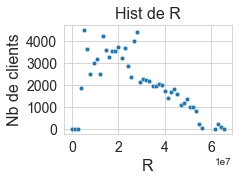

In [39]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(dfs["R"], strlog='')
plt.savefig("Hist_de_R.png",
            bbox_inches="tight")
print()

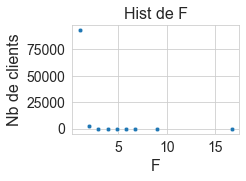

In [40]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(dfs["F"], strlog='')
plt.savefig("Hist_de_F.png",
            bbox_inches="tight")
print()

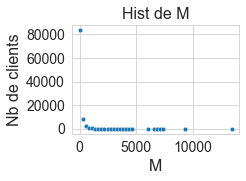

In [41]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(dfs["M"], strlog='')
plt.savefig("Hist_de_M.png",
            bbox_inches="tight")
print()

>>-
## 33. log(F), log(M)

In [42]:
display(dfs.head(1))
dfs.F = np.log(1+dfs.F)/np.log(2)
dfs.M = np.log(1+dfs.M)/np.log(2)
dfs.head(1)

,R,F,M
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,13847631.0,1,141.9


,R,F,M
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,13847631.0,1.0,7.158862


In [43]:
dfs.to_csv("dfs_log.csv")
dfs_log = dfs.copy()

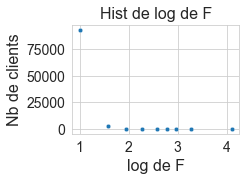

In [44]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(dfs_log.F, strlog='log de ')
plt.savefig("Hist_de_log_de_F.png",
            bbox_inches="tight")
print()

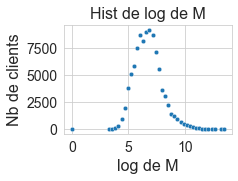

In [45]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(dfs_log.M, strlog='log de ')
plt.savefig("Hist_de_log_de_M.png",
            bbox_inches="tight")
print()

>>-
## 34. logs de F

In [46]:
dfs.F = np.log(1+dfs.F)/np.log(2)

In [47]:
dfs.to_csv("dfs_loglog.csv")
dfs_loglog = dfs.copy()

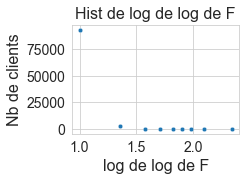

In [48]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(dfs_loglog.F, strlog='log de log de ')
print()

In [49]:
dfs.F = np.log(1+dfs.F)/np.log(2)

In [50]:
dfs.to_csv("dfs_logloglog.csv")
dfs_logloglog = dfs.copy()

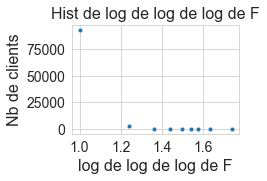

In [51]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(dfs_logloglog.F, strlog='log de log de log de ')
print()

In [52]:
dfs.F = np.log(1+dfs.F)/np.log(2)

In [53]:
dfs.to_csv("dfs_loglogloglog.csv")
dfs_loglogloglog = dfs.copy()

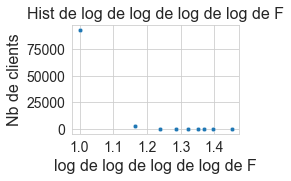

In [54]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(dfs_loglogloglog.F, strlog='log de log de log de log de ')
print()

Clairement la solution n'est pas dans cette direction.

<a id="anchor2"></a>

>-
# Z. Annexe 1 - striptime

In [55]:
pd.to_datetime(df.order_purchase_timestamp).head(2)

0   2017-05-16 15:05:35
1   2018-01-12 20:48:24
Name: order_purchase_timestamp, dtype: datetime64[ns]

In [56]:
pd.to_numeric(pd.to_datetime(df.order_purchase_timestamp)).head(2)

0    1494947135000000000
1    1515790104000000000
Name: order_purchase_timestamp, dtype: int64

>-
# Z. Annexe 2 - groupby-count-groupby-count

[Retour à la construction RFM.](#anchor1)

In [57]:
dd = pd.DataFrame({
    'Client':["Spark","PySpark","Hadoop","Python","PySpark","Spark","Spark"],
    'Prix_unit' :[20000,25000,26000,22000,25000,20000,35000],
    'R':['60days','40days','35days','40days','40days','60days','70days'],
    'Discount':[1000,2300,pd.NA,0,2000,2000,3000]
              })
dd

,Client,Prix_unit,R,Discount
0,Spark,20000,60days,1000
1,PySpark,25000,40days,2300
2,Hadoop,26000,35days,<NA>
3,Python,22000,40days,0
4,PySpark,25000,40days,2000
5,Spark,20000,60days,2000
6,Spark,35000,70days,3000


In [58]:
dd.agg("Client")

0      Spark
1    PySpark
2     Hadoop
3     Python
4    PySpark
5      Spark
6      Spark
Name: Client, dtype: object

In [59]:
dd.Client.agg("count")

7

In [60]:
dd.groupby("Client").agg("count")

,Prix_unit,R,Discount
Client,,,
Hadoop,1,1,0
PySpark,2,2,2
Python,1,1,1
Spark,3,3,3


In [61]:
dd.groupby(["Client","R"]).agg("count")

Prix_unit  Discount
Client  R                          
Hadoop  35days          1         0
PySpark 40days          2         2
Python  40days          1         1
Spark   60days          2         2
        70days          1         1

In [62]:
dd.groupby(["Client","R"]).agg("count").groupby("Client").count()

,Prix_unit,Discount
Client,,
Hadoop,1,1
PySpark,1,1
Python,1,1
Spark,2,2


>-
# Z. Annexe 3 - clustering à la main

In [63]:
dd[["Client","Prix_unit"]].drop_duplicates()

,Client,Prix_unit
0,Spark,20000
1,PySpark,25000
2,Hadoop,26000
3,Python,22000
6,Spark,35000


In [64]:
dd[["Client","Prix_unit"]].drop_duplicates().groupby(["Client","Prix_unit"]).agg("count")

Empty DataFrame
Columns: []
Index: [(Hadoop, 26000), (PySpark, 25000), (Python, 22000), (Spark, 20000), (Spark, 35000)]

In [65]:
dd[["Client","Prix_unit"]].drop_duplicates().groupby(["Client","Prix_unit"]).agg("count").reset_index()

,Client,Prix_unit
0,Hadoop,26000
1,PySpark,25000
2,Python,22000
3,Spark,20000
4,Spark,35000


In [66]:
dd[["Client","Prix_unit"]].drop_duplicates().groupby(["Client","Prix_unit"]).agg("count").sort_values("Client", ascending=False).reset_index()

,Client,Prix_unit
0,Spark,20000
1,Spark,35000
2,Python,22000
3,PySpark,25000
4,Hadoop,26000


Meh. Je ne comprends pas ce qu'il voulait faire.

In [67]:
dd.query("Client=='Spark'")

,Client,Prix_unit,R,Discount
0,Spark,20000,60days,1000
5,Spark,20000,60days,2000
6,Spark,35000,70days,3000


In [68]:
dd[dd["Client"] == "Spark"]

,Client,Prix_unit,R,Discount
0,Spark,20000,60days,1000
5,Spark,20000,60days,2000
6,Spark,35000,70days,3000


useless method apparemment.

In [69]:
dd[pd.notnull(dd.Discount)]

,Client,Prix_unit,R,Discount
0,Spark,20000,60days,1000
1,PySpark,25000,40days,2300
3,Python,22000,40days,0
4,PySpark,25000,40days,2000
5,Spark,20000,60days,2000
6,Spark,35000,70days,3000


In [70]:
quantiles = dfs_1.quantile(q=[.25, .5, .75])
quantiles

,R,F,M
0.25,14159723.5,1.0,6.002703
0.50,23233532.0,1.0,6.768184
0.75,34331009.5,1.0,7.527712


In [71]:
def sc(x,p,d):
    if x <= d[p][.25]:
        return 1
    elif x <= d[p][.5]:
        return 2
    elif x <= d[p][.75]:
        return 3
    else:
        return 4

In [72]:
%%script echo
def sc(x,p,d):
    lstpos = [d[p][.25], d[p][.5], d[p][.75]]
    lstpos = np.sort(lstpos.append(x))
    scs = {0:1,1:2,2:3}
    scs_default = 4
    return scs.get((index de x dans lstpos), scs_default)

Couldn't find program: 'echo'


In [73]:
dfq = dfs_1.copy()
dfq["R"] = dfq["R"].apply(sc, args=("R",quantiles,))
dfq["F"] = dfq["F"].apply(sc, args=("F",quantiles,)).apply(lambda x: 5-x)
dfq["M"] = dfq["M"].apply(sc, args=("M",quantiles,)).apply(lambda x: 5-x)
dfq.head()

,R,F,M
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,4,2
0000b849f77a49e4a4ce2b2a4ca5be3f,1,4,4
0000f46a3911fa3c0805444483337064,4,4,3
0000f6ccb0745a6a4b88665a16c9f078,3,4,4
0004aac84e0df4da2b147fca70cf8255,3,4,1


In [74]:
dfq.R.head(3).to_string()

'customer_unique_id\n0000366f3b9a7992bf8c76cfdf3221e2    1\n0000b849f77a49e4a4ce2b2a4ca5be3f    1\n0000f46a3911fa3c0805444483337064    4'

In [75]:
dfq["g1"] = dfq.R.map(str) + dfq.F.map(str) + dfq.M.map(str)
#dfq["g2"] = list(zip(dfq.R.to_string(),dfq.F.to_string(),dfq.M.to_string())) De nombreuses erreurs dans cette ligne.
dfq["rankn"] = dfq[["R","F","M"]].sum(axis=1)
dfq.head(2)

,R,F,M,g1,rankn
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,4,2,142,7
0000b849f77a49e4a4ce2b2a4ca5be3f,1,4,4,144,9


In [76]:
ranks = ["diam","plat","gold","silver"]
dfq["rankw"] = pd.qcut(dfq.rankn, q=4, labels=ranks).values
dfq.head(2)

,R,F,M,g1,rankn,rankw
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,4,2,142,7,diam
0000b849f77a49e4a4ce2b2a4ca5be3f,1,4,4,144,9,plat


>-
# 4. Restart pour ajout du review_score

>>-
## 41. Merge_1

In [77]:
print("dfs1: " + str(dfs1.shape))
print("dfs6: " + str(dfs6.shape))
df = dfs1[["customer_id","customer_unique_id"]].merge(dfs6[["customer_id","order_id","order_purchase_timestamp"]], on="customer_id", how="outer")
print("df  : " + str(df.shape))
print("dfs4: " + str(dfs4.shape))
df = df.merge(dfs4[["order_id","payment_value"]], on="order_id", how="outer")
print("df  : " + str(df.shape))

dfs1: (99441, 5)
dfs6: (99441, 8)
df  : (99441, 4)
dfs4: (103886, 5)
df  : (103887, 5)


>>-
## 42. Cleaning_1

In [78]:
new_elt = list(set(df.order_id).difference(set(dfs4.order_id)))
#display(df[["order_purchase_timestamp","payment_value","review_score"]][df.order_id == new_elt[0]])
display([df[["order_purchase_timestamp","payment_value"]][df.order_id == i] for i in new_elt[:4]]) # Un seul élément en fait ici, mais j'en demande 4 pour voir.

[      order_purchase_timestamp  payment_value
 22061      2016-09-15 12:16:38            NaN]

In [79]:
print(df.shape)
df = df[df.order_id != new_elt[0]]
df = my.resindx(df)

(103887, 5)
Il n'y avait pas de colonne 'level_0' indésirable à supprimer.
Une colonne 'index' indésirable a été supprimée.
(103886, 5)


In [80]:
df["payment_value"].isna().sum()

0

>>-
## 43. Merge_2

Passons maintenant à l'ajout du review_score.

In [81]:
elts_w_rev = df.shape[0]
print("dfs5: " + str(dfs5.shape))
df = df.merge(dfs5[["order_id","review_score"]], on="order_id", how="outer")
print("df  : " + str(df.shape))
elts_wo_rev = df.shape[0] - elts_w_rev
print("Nombre d'éléments sans review_score  : " + str(elts_wo_rev))

dfs5: (99224, 7)
df  : (104478, 6)
Nombre d'éléments sans review_score  : 592


>>-
## 44. Cleaning_2 (et re-cleaning_1)

In [82]:
new_elts = list(set(df.order_id).difference(set(dfs5.order_id)))
#display([df[["order_purchase_timestamp","payment_value","review_score"]][df.order_id == i] for i in new_elts][:4]) # Celui-ci fait davantage sens mais il est long en calculs pour rien.
display([df[["order_purchase_timestamp","payment_value","review_score"]][df.order_id == i] for i in new_elts[:4]]) # 591 éléments en fait ici.

[      order_purchase_timestamp  payment_value  review_score
 13274      2018-04-20 14:54:15          62.25           NaN,
       order_purchase_timestamp  payment_value  review_score
 85543      2018-02-20 10:31:58         101.03           NaN,
       order_purchase_timestamp  payment_value  review_score
 15787      2017-12-14 00:06:50          62.01           NaN,
       order_purchase_timestamp  payment_value  review_score
 34595      2018-05-04 15:59:47         145.76           NaN]

In [83]:
df[["order_id","order_purchase_timestamp","payment_value","review_score"]].duplicated(keep=False).sum()

1653

In [84]:
df[["order_id","order_purchase_timestamp","payment_value","review_score"]][df["review_score"].isna() == False].duplicated(keep=False).sum()

1648

Il y a de nouveau beaucoup de duplicates dans le df mergé.

In [85]:
df[df[["order_id","order_purchase_timestamp","payment_value","review_score"]].duplicated(keep=False)][:2]

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,payment_value,review_score
312,dcb6e7bc4e65d815025d0aa14349a4ca,a1864cdd58debf5031958069ee937742,dfaa4ce943a8dba10b754befb76fdb49,2017-11-26 15:11:19,189.88,4.0
313,dcb6e7bc4e65d815025d0aa14349a4ca,a1864cdd58debf5031958069ee937742,dfaa4ce943a8dba10b754befb76fdb49,2017-11-26 15:11:19,189.88,4.0


In [86]:
dfs5[dfs5[["order_id","review_score"]].duplicated(keep=False)].sort_values(by="order_id")[:10]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
25612,89a02c45c340aeeb1354a24e7d4b2c1e,0035246a40f520710769010f752e7507,5,NaN,NaN,2017-08-29 00:00:00,2017-08-30 01:59:12
22423,2a74b0559eb58fc1ff842ecc999594cb,0035246a40f520710769010f752e7507,5,NaN,Estou acostumada a comprar produtos pelo barat...,2017-08-25 00:00:00,2017-08-29 21:45:57
854,830636803620cdf8b6ffaf1b2f6e92b2,0176a6846bcb3b0d3aa3116a9a768597,5,NaN,NaN,2017-12-30 00:00:00,2018-01-02 10:54:06
83224,d8e8c42271c8fb67b9dad95d98c8ff80,0176a6846bcb3b0d3aa3116a9a768597,5,NaN,NaN,2017-12-30 00:00:00,2018-01-02 10:54:47
17847,2eab0b2e6f5bded4d9b0b2afcfdf4534,02e0b68852217f5715fb9cc885829454,4,NaN,Gostei chegou rapidinho,2017-12-03 00:00:00,2017-12-03 21:56:37
35812,fa493ead9b093fb0fa6f7d4905b0ef3b,02e0b68852217f5715fb9cc885829454,4,NaN,Gostei e entregou rapidinho,2017-12-01 00:00:00,2017-12-03 21:57:31
35052,38821b5c496b678cf91acc34892805ad,02e723e8edb4a123d414f56cc9c4665e,5,NaN,NaN,2017-09-03 00:00:00,2017-09-05 12:12:51
42500,39b4603793c1c7f5f36d809b4a218664,02e723e8edb4a123d414f56cc9c4665e,5,NaN,Otimo,2017-09-01 00:00:00,2017-09-02 12:13:03
38386,1dee9d450a2b8533d2085cef898ca4a2,03515a836bb855b03f7df9dee520a8fc,5,NaN,NaN,2018-02-06 00:00:00,2018-02-06 17:19:21
49625,5e1ee2e924a1dd10d80b99555383c0a7,03515a836bb855b03f7df9dee520a8fc,5,NaN,NaN,2018-01-31 00:00:00,2018-02-01 01:26:24


In [87]:
dfs5[["order_id","review_score"]].duplicated(keep=False).sum()

696

In [88]:
dfs5["review_score"].isna().sum()

0

Cette fois on trouve beaucoup de duplicates dans le df mergé que ceux qui existaient déjà dans dfs5.  
Il me semble que c'est parce que je n'arrive pas à isoler dans le df mergé uniquement les duplicates qui proviennent de dfs5, que je compte d'autres duplicates qui seraient là même sans le merge avec dfs5 et les éventuelles erreurs qu'il cause.

In [89]:
dfs4[["order_id","payment_value"]].duplicated(keep=False).sum() + dfs5[["order_id","review_score"]].duplicated(keep=False).sum()

1619

In [90]:
df["review_score"].isna().sum()

800

J'ai du mal à savoir quelle décision prendre ici.  
Il y a normalement ```elts_wo_rev``` (=592) lignes à supprimer de df, puis ```df["review_score"].isna().sum() - elts_wo_rev``` (=209) review_scores à imputer pour les order_id qui (déjà dans la base de données relationnelle avant que je ne merge) ont un "payment_value" mais n'ont pas de "review_score".  
Cependant, je ne sais pas encore comment trouver ces 209 éléments légitimes sans review_score.

In [91]:
df["payment_value"].isna().sum()

1

In [92]:
print(id_sans_payt_val)
df["order_id"][df["payment_value"].isna() == True]

22061    bfbd0f9bdef84302105ad712db648a6c
Name: order_id, dtype: object


104477    bfbd0f9bdef84302105ad712db648a6c
Name: order_id, dtype: object

L'order_id qui n'avait pas de payment_value a été ré-attribué au df lors du merge de dfs5 car cet order_id existe dans dfs5. Celui-ci est facile à supprimer.

In [93]:
print(df.shape)
df = df[df.order_id != new_elt[0]]
df = my.resindx(df)

(104478, 6)
Il n'y avait pas de colonne 'level_0' indésirable à supprimer.
Une colonne 'index' indésirable a été supprimée.
(104477, 6)


In [94]:
df["payment_value"].isna().sum()

0

Ici: Test en supprimant tous les éléments sans "review_score".

In [95]:
print(df.shape)
df = df[df.review_score.isna() == False]
df = my.resindx(df)

(104477, 6)
Il n'y avait pas de colonne 'level_0' indésirable à supprimer.
Une colonne 'index' indésirable a été supprimée.
(103677, 6)


In [96]:
df["review_score"].isna().sum()

0

800 éléments supprimés. Voyons si cette décision est raisonnable.

>>-
## 45. Feature cleaning

Je nettoie les colonnes inutiles:

In [97]:
keeps.append("review_score")
df = df[keeps]
df.head(2)

,customer_unique_id,order_purchase_timestamp,payment_value,review_score
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,146.87,4.0
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,335.48,5.0


In [98]:
df.isna().sum()

customer_unique_id          0
order_purchase_timestamp    0
payment_value               0
review_score                0
dtype: int64

In [99]:
dfs.isna().sum()

R    0
F    0
M    0
dtype: int64

>>-
## 46. Réorganisation RFM + rs

In [100]:
#t0 = datetime.datetime.strptime(df.order_purchase_timestamp.max(), "%Y-%m-%d %H:%M:%S")
df["recency_2"] = pd.to_numeric(pd.to_datetime(df.order_purchase_timestamp))
df["recency_2"] = (df.recency_2.max() - df.recency_2)*10**-9

In [101]:
dfs = pd.DataFrame()
dfs["R"] = df.groupby("customer_unique_id").recency_2.min()
dfs["F"] = df.groupby(
    ["customer_unique_id","order_purchase_timestamp"]
).agg("count").groupby("customer_unique_id").count().payment_value
dfs["M"] = df.groupby("customer_unique_id").payment_value.sum()
dfs_rsmin = dfs.copy()
dfs["rs"] = df.groupby("customer_unique_id").review_score.mean()
dfs_rsmin["rs"] = df.groupby("customer_unique_id").review_score.min()
dfs.head()

,R,F,M,rs
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,13847631.0,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,14105931.0,1,27.19,4.0
0000f46a3911fa3c0805444483337064,50617515.0,1,86.22,3.0
0000f6ccb0745a6a4b88665a16c9f078,31957237.0,1,43.62,4.0
0004aac84e0df4da2b147fca70cf8255,29108676.0,1,196.89,5.0


In [102]:
%%script echo Cette cell ne fonctionnera pas, je la fabrique juste pour le ppt
df["recency_2"] = pd.to_numeric(pd.to_datetime(df.order_purchase_timestamp))
df["recency_2"] = (df.recency_2.max() - df.recency_2)*10**-9
dfs["R"] = df.groupby("customer_unique_id").recency_2.min()
dfs["F"] = df.groupby(
    ["customer_unique_id","order_purchase_timestamp"]
).agg("count").groupby("customer_unique_id").count().payment_value
dfs["M"] = df.groupby("customer_unique_id").payment_value.sum()
dfs["rs"] = df.groupby("customer_unique_id").review_score.min()
dfs.head()

Couldn't find program: 'echo'


In [103]:
print(dfs.shape[0], ", ", sum(dfs.F == 1))
pct = (1-sum(dfs.F == 1)/dfs.shape[0])*100
pct = (sum(dfs.F > 1)/dfs.shape[0])*100 # idem car par construction F < 1 n'existe pas.
print("Il y a {a:.1f}% de clients ayant effectué plus d'un achat dans le dataset avant subsampling.".format(a=pct))

95379 ,  92680
Il y a 2.8% de clients ayant effectué plus d'un achat dans le dataset avant subsampling.


Ok ça va au moins on a conservé les ~3% de clients à 2+ achats.

In [104]:
dfs.to_csv("dfs_rs_mean.csv")
dfs_rs_mean = dfs.copy()

In [105]:
dfs_rsmin.to_csv("dfs_rs_min.csv")
#dfs_rs_min = dfs_rsmin.copy()

In [106]:
#dfs = pd.read_csv("dfs_rs.csv")

>>-
## 47. Visualisation du rs

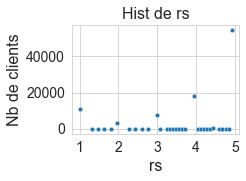

In [107]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(dfs["rs"], strlog='')
print()

Seuls les 3% de clients qui ont fait 2+ commandes ont pu laisser plus d'une review et donc peuvent avoir un mean() de review_score non-entier.

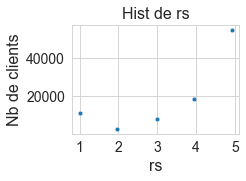

In [108]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(3, 2))
my.hstplot(dfs_rsmin["rs"], strlog='')
plt.savefig("Hist_de_S.png",
            bbox_inches="tight")
print()

(Je vérifie les valeurs de rs car sur le graphe les points semblent mal placés.)

In [109]:
set(dfs_rsmin.rs)

{1.0, 2.0, 3.0, 4.0, 5.0}

Je vais travailler avec les min() de rs plutôt qu'avec les mean() ça sera plus simple.  
Je préfère prendre les min() plutôt que les max() car j'estime que le comportement d'achat des clients est mieux expliqué par les achats auxquels ils ont attribué une mauvaise note que par les achats dont ils ont été satisfaits. (Un achat satisfaisant implique rarement un nouvel achat alors qu'un achat problématique va souvent impliquer la perte du client.)